In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

EXP_NAME = "autoencoder-paraphrase"
PROJECT_ROOT = "/home/jovyan/vmeshchaninov/LatentDiffusion"
EXP_RESULT_PATH = f"{PROJECT_ROOT}/experiments/results/{EXP_NAME}/"
os.makedirs(EXP_RESULT_PATH, exist_ok=True)
sys.path.append(PROJECT_ROOT)
os.environ["PROJECT_ROOT"] = PROJECT_ROOT

In [3]:
import torch
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra.core.global_hydra import GlobalHydra

from encoder_trainer import EncoderTrainer

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import rel_entr  # KL divergence computation

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reset Hydra to avoid conflicts if already initialized
GlobalHydra.instance().clear()

# Initialize Hydra and load config manually
hydra.initialize(config_path="../conf", version_base=None)  # Set path to your configs

# Load the configuration
cfg = hydra.compose(config_name="config")  # Replace with your main config file

# Print the loaded config
print(OmegaConf.to_yaml(cfg))

autoencoder:
  model:
    checkpoints_prefix: autoencoder
    text_encoder: bert-base-cased
    text_encoder_freeze_params: true
    num_workers: 30
    load_checkpoint: true
  loss:
    level_weights:
    - 1.0
    - 1.0
    - 1.0
    - 1.0
    - 1.0
    - 1.0
  training:
    training_iters: 100000
    batch_size: 512
    batch_size_per_gpu: 512
  params:
    text_encoder: 0
    encoder: 0
    decoder: 0
    total: 0
  all_params: dict()
  logging:
    log_freq: 10
    eval_freq: 20000
    save_freq: 20000
  optimizer:
    name: stableadam
    learning_rate: 0.0002
    warmup_lr: 1.0e-08
    min_lr: 0.0001
    weight_decay: 1.0e-05
    eps: 1.0e-06
    betas:
    - 0.9
    - 0.98
    linear_warmup: 10
    grad_clip_norm: 10.0
encoder:
  attention:
    head_size: 64
    num_heads: 12
    probs_dropout: 0.0
    qk_norm: true
    implementation: flash_attention_2
  embedding:
    dim: 768
    max_position_embeddings: 128
    initializer_range: 0.02
  hidden:
    size: 768
    dropout: 0.

/home/jovyan/.mlspace/envs/dif_env/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [5]:

from datasets import Dataset, load_from_disk

In [67]:
# Setup the config
cfg.ddp.enabled = False
cfg.autoencoder.model.load_checkpoint = "autoencoder-num_latents=16-wikipedia-v2.4.2-128/100000.pth"


In [68]:
trainer = EncoderTrainer(cfg)

/home/jovyan/vmeshchaninov/LatentDiffusion/encoder_trainer.py:194: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.grad_scaler = GradScaler()


Checkpotint autoencoder-num_latents=16-wikipedia-v2.4.2-128/100000.pth loaded


In [69]:
trainer.encoder.eval()
trainer.decoder.eval()
print()

In [8]:
path_to_data = f"{PROJECT_ROOT}/data/en_wiki_paraphrase"
data = load_from_disk(path_to_data)

In [9]:
data.column_names

['anchor',
 'positive',
 'positive_score',
 'hard_negative_1',
 'hard_negative_score_1',
 'hard_negative_2',
 'hard_negative_score_2']

In [16]:
def get_latent(text):
    tokenized = trainer.tokenizer(
        text,
        add_special_tokens=True,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt",
        return_attention_mask=True,
        return_token_type_ids=False,
    ).to(device)

    with torch.autocast(device_type='cuda', dtype=torch.bfloat16), torch.no_grad():
        latent, _ = trainer.get_latent(tokenized)
    latent = trainer.normalize_latent(latent)
    return latent, tokenized


# Old

In [168]:
anchor_latent, anchor_tokenized = get_latent(data["anchor"])
positive_latent, positive_tokenized = get_latent(data["positive"])
hard_negative_latent, hard_negative_tokenized = get_latent(data["hard_negative_1"])

print(anchor_latent.shape)

/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


torch.Size([10000, 768])


In [169]:
positive_texts = data["positive"]
negative_texts = []
for i in range(len(positive_texts)):
    random_index = i
    while i == random_index:
        random_index = np.random.randint(0, len(positive_texts))

    negative_texts.append(positive_texts[random_index])

negative_latent, negative_tokenized = get_latent(negative_texts)

In [170]:
def cosine(a, b):
    a = a / torch.norm(a, dim=1, p=2)[:, None]
    b = b / torch.norm(b, dim=1, p=2)[:, None]
    return torch.sum(a * b, dim=1)

In [171]:
num_samples = anchor_latent.shape[0]

with torch.autocast(device_type='cuda', dtype=torch.bfloat16), torch.no_grad():
    positive_scores = (cosine(anchor_latent.reshape(num_samples, -1), positive_latent.reshape(num_samples, -1)) * 100.).detach().cpu()
    hard_negative_scores = (cosine(anchor_latent.reshape(num_samples, -1), hard_negative_latent.reshape(num_samples, -1)) * 100.).detach().cpu()
    negative_scores = (cosine(anchor_latent.reshape(num_samples, -1), negative_latent.reshape(num_samples, -1)) * 100.).detach().cpu()

In [172]:
def KL_divergence(positive_scores, negative_scores, bins):
    # Compute histograms
    positive_hist, _ = np.histogram(positive_scores, bins=bins, density=True)
    negative_hist, _ = np.histogram(negative_scores, bins=bins, density=True)

    # Avoid zero probabilities by adding a small constant (epsilon)
    epsilon = 1e-10
    positive_hist += epsilon
    negative_hist += epsilon

    # Compute KL divergence (P || Q)
    kl_div = np.sum(rel_entr(positive_hist, negative_hist))

    return kl_div

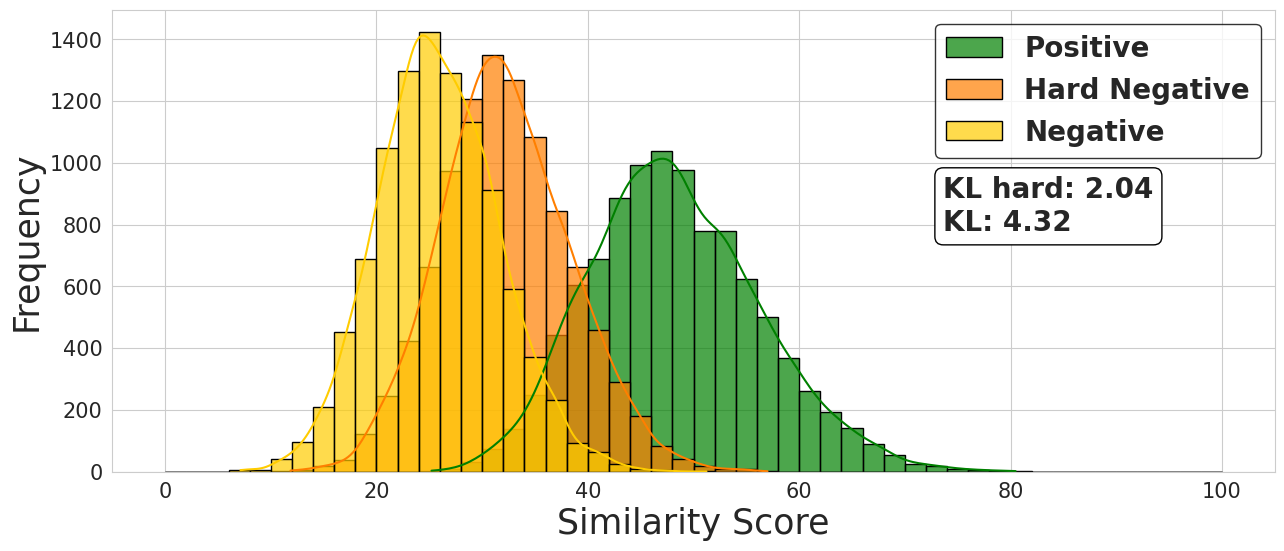

In [173]:
# Set the style for an awesome look
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))

font_size = 20
num_bins = 50
bins = np.linspace(0, 100, num_bins + 1)

# Plot histograms
sns.histplot(positive_scores, bins=bins, kde=True, color="green", label="Positive", alpha=0.7, edgecolor="black")
sns.histplot(hard_negative_scores, bins=bins, kde=True, color="#FF7F00", label="Hard Negative", alpha=0.7, edgecolor="black")
sns.histplot(negative_scores, bins=bins, kde=True, color="#FFCC00", label="Negative", alpha=0.7, edgecolor="black")

# Add title and labels with a creative touch
# Title with colored text
# plt.title("Positivity vs Negativity: A Histogram of Contrasts", fontsize=font_size + 10, fontweight="bold", pad=15)

plt.xlabel("Similarity Score", fontsize=font_size + 5)
plt.ylabel("Frequency", fontsize=font_size + 5)

# Adjust tick sizes
plt.xticks(fontsize=font_size - 5)
plt.yticks(fontsize=font_size - 5)

# Add legend
legend = plt.legend(frameon=True, loc="upper right", prop={'weight': 'bold', 'size': font_size}, edgecolor="black")  # Positioned at the upper right with bold text

# Get legend position
legend_bbox = legend.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())

# Add KL Divergence text below the legend
kl_hard = KL_divergence(positive_scores, hard_negative_scores, bins)
kl = KL_divergence(positive_scores, negative_scores, bins)

plt.gcf().text(
    (plt.gcf().dpi_scale_trans.get_matrix()[0, 0] - legend_bbox.x0 - 22) / plt.gcf().dpi_scale_trans.get_matrix()[0, 0],
    (plt.gcf().dpi_scale_trans.get_matrix()[1, 1] - legend_bbox.y0 - 45) / plt.gcf().dpi_scale_trans.get_matrix()[1, 1],  # Match legend x position
    f"KL hard: {kl_hard:.2f}\n" + f"KL: {kl:.2f}",
    fontsize=font_size, fontweight="bold", 
    bbox=dict(facecolor="white", alpha=1.0, edgecolor="black", boxstyle="round")
)


# Save as PDF
plt.savefig(f"{PROJECT_ROOT}/experiments/results/{EXP_NAME}/histogram.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [174]:
import json

result = {
    "positive_scores": positive_scores.tolist(),
    "hard_negative_scores": hard_negative_scores.tolist(),
    "negative_scores": negative_scores.tolist(),
    "kl_hard": kl_hard,
    "kl": kl,
}
json.dump(result, open(f"{PROJECT_ROOT}/experiments/results/{EXP_NAME}/result.json", "w"), indent=4)

# Difference between positive and negative distance

In [12]:
text_dict = {
    "anchor": data["anchor"],
    "positive": data["positive"],
}

text_dict["negative"] = []
for i in range(len(text_dict["positive"])):
    random_index = i
    while i == random_index:
        random_index = np.random.randint(0, len(text_dict["positive"]))
    text_dict["negative"].append(text_dict["positive"][random_index])

In [47]:
anchor_latent, _ = get_latent(text_dict["anchor"])
positive_latent, _ = get_latent(text_dict["positive"])
negative_latent, _ = get_latent(text_dict["negative"])

/home/jovyan/.mlspace/envs/dif_env/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [48]:
anchor_latent = anchor_latent.reshape(len(anchor_latent), -1)
positive_latent = positive_latent.reshape(len(positive_latent), -1)
negative_latent = negative_latent.reshape(len(negative_latent), -1)


In [49]:
def cosine_distance(a, b):
    a = a / torch.norm(a, dim=1, p=2)[:, None]
    b = b / torch.norm(b, dim=1, p=2)[:, None]
    return 1 - torch.sum(a * b, dim=1)


In [50]:
positive_distance = cosine_distance(anchor_latent, positive_latent)
negative_distance = cosine_distance(anchor_latent, negative_latent)

In [51]:
dif_distance = negative_distance - positive_distance

In [52]:
import json

json.dump({
    "positive_distance": positive_distance.detach().cpu().tolist(),
    "negative_distance": negative_distance.detach().cpu().tolist(),
    "dif_distance": dif_distance.detach().cpu().tolist()
}, 
    open(f"{PROJECT_ROOT}/experiments/results/{EXP_NAME}/{cfg.autoencoder.model.load_checkpoint.split('/')[-2]}.json", "w"), 
    indent=4
)


In [55]:
data_v10 = json.load(
    open(f"{PROJECT_ROOT}/experiments/results/{EXP_NAME}/autoencoder-num_latents=16-wikipedia-v1.0-128.json", "r")
)
data_v227 = json.load(
    open(f"{PROJECT_ROOT}/experiments/results/{EXP_NAME}/autoencoder-num_latents=16-wikipedia-v2.2.7-128.json", "r")
)
data_v242 = json.load(
    open(f"{PROJECT_ROOT}/experiments/results/{EXP_NAME}/autoencoder-num_latents=16-wikipedia-v2.4.2-128.json", "r")
)







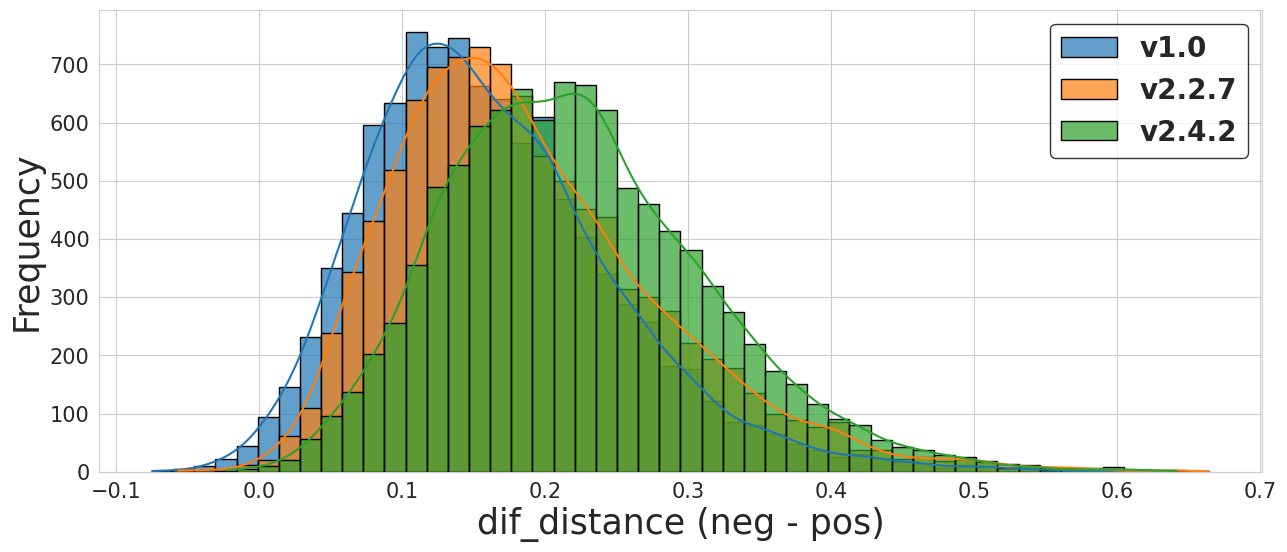

In [56]:
# Plot three histograms of dif_distance for v1.0, v2.2.7, v2.4.2
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))

font_size = 20
num_bins = 50

# Extract dif_distance arrays
dif_v10  = np.array(data_v10["dif_distance"])
dif_v227 = np.array(data_v227["dif_distance"])
dif_v242 = np.array(data_v242["dif_distance"])

# Build common bin edges over all three datasets
min_edge = min(dif_v10.min(), dif_v227.min(), dif_v242.min())
max_edge = max(dif_v10.max(), dif_v227.max(), dif_v242.max())
bins = np.linspace(min_edge, max_edge, num_bins + 1)

# Plot histograms
sns.histplot(dif_v10,  bins=bins, kde=True, color="C0", label="v1.0",   alpha=0.7, edgecolor="black")
sns.histplot(dif_v227, bins=bins, kde=True, color="C1", label="v2.2.7", alpha=0.7, edgecolor="black")
sns.histplot(dif_v242, bins=bins, kde=True, color="C2", label="v2.4.2", alpha=0.7, edgecolor="black")

# Labels and styling
plt.xlabel("dif_distance (neg - pos)", fontsize=font_size + 5)
plt.ylabel("Frequency",               fontsize=font_size + 5)
plt.xticks(fontsize=font_size - 5)
plt.yticks(fontsize=font_size - 5)

# Legend
plt.legend(
    frameon=True,
    loc="upper right",
    prop={'weight': 'bold', 'size': font_size},
    edgecolor="black"
)

# Save and show
plt.savefig(
    f"{PROJECT_ROOT}/experiments/results/{EXP_NAME}/dif_distance_histograms.pdf",
    format="pdf",
    bbox_inches="tight"
)
plt.show()

# Discretness of space

In [57]:
path_to_data = f"{PROJECT_ROOT}/data/rocstories"
data = load_from_disk(path_to_data)

selected_data = data["train"].shuffle(seed=42).select(range(10000))
selected_data = selected_data["text_trg"]

In [70]:
data_latent, _ = get_latent(selected_data)
data_latent = data_latent.reshape(len(data_latent), -1)

/home/jovyan/.mlspace/envs/dif_env/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [71]:
mean_latent = torch.mean(data_latent, dim=0)
std_latent = torch.std(data_latent, dim=0)

normalized_latent = (data_latent - mean_latent) / std_latent

In [65]:
def inner_distance(latents, type="min"):
    if type == "min":
        return torch.min(torch.cdist(latents, latents), dim=1)[0].mean()
    elif type == "max":
        return torch.max(torch.cdist(latents, latents), dim=1)[0].mean()
    elif type == "mean":
        return torch.mean(torch.cdist(latents, latents), dim=1).mean()


In [66]:
mean_distance = inner_distance(normalized_latent, type="mean")
min_distance = inner_distance(normalized_latent, type="min")
max_distance = inner_distance(normalized_latent, type="max")

print(f"Mean distance: {mean_distance}")
print(f"Min distance: {min_distance}")
print(f"Max distance: {max_distance}")

Mean distance: 156.6337432861328
Min distance: 0.1223607137799263
Max distance: 172.40065002441406


In [72]:
mean_distance = inner_distance(normalized_latent, type="mean")
min_distance = inner_distance(normalized_latent, type="min")
max_distance = inner_distance(normalized_latent, type="max")

print(f"Mean distance: {mean_distance}")
print(f"Min distance: {min_distance}")
print(f"Max distance: {max_distance}")

Mean distance: 156.72023010253906
Min distance: 0.12261784076690674
Max distance: 165.7148895263672
